In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
import sys
import time, datetime
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.cuda import amp
from spikingjelly.activation_based import neuron, encoding, functional, surrogate, layer
from torchvision import datasets, transforms
from tqdm import tqdm
from spikingjelly.clock_driven.neuron import MultiStepLIFNode
from timm.layers import to_2tuple, trunc_normal_, DropPath
import torchvision

AttributeError: module 'distutils' has no attribute 'version'

# 基础部分： 
跑通SNN+MNIST，解释现有代码的原理，调整网络层及参数，观察效果；上限80分

In [ ]:
# MNIST数据集获取
# 设置数据转换，这里我们只进行归一化处理
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)),
])

# 下载并加载训练、测试数据集
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainloader_mnist = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=4)
testloader_mnist = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=4)

In [ ]:
# 全连接网络层
# 一个隐藏层全连接网络
class SNN(nn.Module):
    def __init__(self, tau):
        super().__init__()

        self.layer = nn.Sequential(
            layer.Flatten(),
            layer.Linear(1 * 28 * 28, 10, bias=False),
            neuron.LIFNode(tau=tau, surrogate_function=surrogate.ATan()),
        )

    def forward(self, x: torch.Tensor):
        return self.layer(x)

# 卷积神经网络 
class CSNN(nn.Module):
    def __init__(self, T: int, channels: int, use_cupy=False):
        super().__init__()
        self.T = T  #SNN时间步长

        self.conv_fc = nn.Sequential(
        layer.Conv2d(1, channels, kernel_size=3, padding=1, bias=False),    #普通卷积层
        layer.BatchNorm2d(channels),                                        #普通BatchNormalization
        neuron.IFNode(surrogate_function=surrogate.ATan()),                 # IF脉冲节点
        layer.MaxPool2d(2, 2),  # 14 * 14                                   # 最大池化

        layer.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False), #普通卷积层
        layer.BatchNorm2d(channels),                                        #普通BatchNormalization
        neuron.IFNode(surrogate_function=surrogate.ATan()),                 #IF 脉冲节点
        layer.MaxPool2d(2, 2),  # 7 * 7                                     # 最大池化

        layer.Flatten(),
        layer.Linear(channels * 7 * 7, channels * 4 * 4, bias=False),       #普通线性层
        neuron.IFNode(surrogate_function=surrogate.ATan()),                 #IF 脉冲节点

        layer.Linear(channels * 4 * 4, 10, bias=False),         
        neuron.IFNode(surrogate_function=surrogate.ATan()),
        )

        functional.set_step_mode(self, step_mode='m')                       #多步脉冲模式

        if use_cupy:
            functional.set_backend(self, backend='cupy')

    def forward(self, x: torch.Tensor):
        # x.shape = [N, C, H, W]
        x_seq = x.unsqueeze(0).repeat(self.T, 1, 1, 1, 1)  # [N, C, H, W] -> [T, N, C, H, W]  #将数据复制T份直接输入网络
        x_seq = self.conv_fc(x_seq)
        fr = x_seq.mean(0)
        return fr
    
    def spiking_encoder(self):
        return self.conv_fc[0:3] #脉冲节点即可将float输入编码为spike序列

In [ ]:
# 主干代码
def main():
    class parser:
        def __init__(self):
            self.T = 4
            self.device='cuda'
            self.epochs = 100
            self.b = 32
            self.j = 4
            self.data_dir='./data'
            self.out_dir='./logs'
            self.resume = None
            self.amp = False
            self.opt = 'adam'
            self.lr=1e-3
            self.tau=2.0
            self.channels = 128
            self.cupy = False
    '''        
    parser = argparse.ArgumentParser(description='LIF MNIST Training')
    parser.add_argument('-T', default=100, type=int, help='simulating time-steps')
    parser.add_argument('-device', default='cuda:0', help='device')
    parser.add_argument('-b', default=64, type=int, help='batch size')
    parser.add_argument('-epochs', default=100, type=int, metavar='N',
                        help='number of total epochs to run')
    parser.add_argument('-j', default=4, type=int, metavar='N',
                        help='number of data loading workers (default: 4)')
    parser.add_argument('-data-dir', type=str, help='root dir of MNIST dataset')
    parser.add_argument('-out-dir', type=str, default='./logs', help='root dir for saving logs and checkpoint')
    parser.add_argument('-resume', type=str, help='resume from the checkpoint path')
    parser.add_argument('-amp', action='store_true', help='automatic mixed precision training')
    parser.add_argument('-opt', type=str, choices=['sgd', 'adam'], default='adam', help='use which optimizer. SGD or Adam')
    parser.add_argument('-momentum', default=0.9, type=float, help='momentum for SGD')
    parser.add_argument('-lr', default=1e-3, type=float, help='learning rate')
    parser.add_argument('-tau', default=2.0, type=float, help='parameter tau of LIF neuron')
    '''
    args = parser()
    print(args)

    net = CSNN(T=args.T, channels=args.channels, use_cupy=args.cupy)
    print(net)
    net = net.to(args.device)

    start_epoch = 0
    max_test_acc = -1
    optimizer = torch.optim.Adam(net.parameters(), lr=args.lr)

    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs)

    out_dir = os.path.join(args.out_dir, f'T{args.T}_b{args.b}_{"adam"}_lr{args.lr}_c{args.channels}')

    if not os.path.exists(out_dir):
        os.makedirs(out_dir)


    for epoch in range(start_epoch, args.epochs):
        start_time = time.time()
        net.train()
        train_loss = 0
        train_acc = 0
        train_samples = 0
        for img, label in tqdm(trainloader_mnist):
            optimizer.zero_grad()          #reset optimizer
            img = img.to(args.device)
            label = label.to(args.device)
            label_onehot = F.one_hot(label, 10).float() #one-hot encoding the label to a vector


            out_fr = net(img)
            loss = F.mse_loss(out_fr, label_onehot)
            loss.backward()
            optimizer.step()

            train_samples += label.numel()
            train_loss += loss.item() * label.numel()
            train_acc += (out_fr.argmax(1) == label).float().sum().item()
            functional.reset_net(net)

        train_time = time.time()
        train_speed = train_samples / (train_time - start_time)
        train_loss /= train_samples
        train_acc /= train_samples

        writer.add_scalar('train_loss', train_loss, epoch)
        writer.add_scalar('train_acc', train_acc, epoch)
        lr_scheduler.step()

        net.eval()
        test_loss = 0
        test_acc = 0
        test_samples = 0
        with torch.no_grad():
            for img, label in testloader_mnist:
                img = img.to(args.device)
                label = label.to(args.device)
                label_onehot = F.one_hot(label, 10).float()
                out_fr = net(img)
                loss = F.mse_loss(out_fr, label_onehot)

                test_samples += label.numel()
                test_loss += loss.item() * label.numel()
                test_acc += (out_fr.argmax(1) == label).float().sum().item()
                functional.reset_net(net)
        test_time = time.time()
        test_speed = test_samples / (test_time - train_time)
        test_loss /= test_samples
        test_acc /= test_samples
        writer.add_scalar('test_loss', test_loss, epoch)
        writer.add_scalar('test_acc', test_acc, epoch)

        save_max = False
        if test_acc > max_test_acc:
            max_test_acc = test_acc
            save_max = True

        checkpoint = {
            'net': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'epoch': epoch,
            'max_test_acc': max_test_acc
        }

        if save_max:
            torch.save(checkpoint, os.path.join(out_dir, 'checkpoint_max.pth'))

        torch.save(checkpoint, os.path.join(out_dir, 'checkpoint_latest.pth'))

        print(args)
        print(out_dir)
        print(f'epoch = {epoch}, train_loss ={train_loss: .4f}, train_acc ={train_acc: .4f}, test_loss ={test_loss: .4f}, test_acc ={test_acc: .4f}, max_test_acc ={max_test_acc: .4f}')
        print(f'train speed ={train_speed: .4f} images/s, test speed ={test_speed: .4f} images/s')
        print(f'escape time = {(datetime.datetime.now() + datetime.timedelta(seconds=(time.time() - start_time) * (args.epochs - epoch))).strftime("%Y-%m-%d %H:%M:%S")}\n')
main()

# 中级部分
实现Transformer/Mamba等新兴网络结构+SNN+算法，在MNIST变种上取得较好效果，如Colored MNIST等。


In [2]:
# 模型spikeformer
# __all__ = ['spikformer']


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1_linear = nn.Linear(in_features, hidden_features)
        self.fc1_bn = nn.BatchNorm1d(hidden_features)
        self.fc1_lif = MultiStepLIFNode(tau=2.0, backend='cupy')

        self.fc2_linear = nn.Linear(hidden_features, out_features)
        self.fc2_bn = nn.BatchNorm1d(out_features)
        self.fc2_lif = MultiStepLIFNode(tau=2.0, backend='cupy')

        self.c_hidden = hidden_features
        self.c_output = out_features

    def forward(self, x):
        T,B,N,C = x.shape
        x_ = x.flatten(0, 1)
        x = self.fc1_linear(x_)
        x = self.fc1_bn(x.transpose(-1, -2)).transpose(-1, -2).reshape(T, B, N, self.c_hidden).contiguous()
        x = self.fc1_lif(x)

        x = self.fc2_linear(x.flatten(0,1))
        x = self.fc2_bn(x.transpose(-1, -2)).transpose(-1, -2).reshape(T, B, N, C).contiguous()
        x = self.fc2_lif(x)
        return x


class SSA(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."
        self.dim = dim
        self.num_heads = num_heads
        self.scale = 0.125
        self.q_linear = nn.Linear(dim, dim)
        self.q_bn = nn.BatchNorm1d(dim)
        self.q_lif = MultiStepLIFNode(tau=2.0, backend='cupy')

        self.k_linear = nn.Linear(dim, dim)
        self.k_bn = nn.BatchNorm1d(dim)
        self.k_lif = MultiStepLIFNode(tau=2.0, backend='cupy')

        self.v_linear = nn.Linear(dim, dim)
        self.v_bn = nn.BatchNorm1d(dim)
        self.v_lif = MultiStepLIFNode(tau=2.0, backend='cupy')
        self.attn_lif = MultiStepLIFNode(tau=2.0, v_threshold=0.5, backend='cupy')

        self.proj_linear = nn.Linear(dim, dim)
        self.proj_bn = nn.BatchNorm1d(dim)
        self.proj_lif = MultiStepLIFNode(tau=2.0, backend='cupy')

    def forward(self, x):
        T,B,N,C = x.shape

        x_for_qkv = x.flatten(0, 1)  # TB, N, C
        q_linear_out = self.q_linear(x_for_qkv)  # [TB, N, C]
        q_linear_out = self.q_bn(q_linear_out. transpose(-1, -2)).transpose(-1, -2).reshape(T, B, N, C).contiguous()
        q_linear_out = self.q_lif(q_linear_out)
        q = q_linear_out.reshape(T, B, N, self.num_heads, C//self.num_heads).permute(0, 1, 3, 2, 4).contiguous()

        k_linear_out = self.k_linear(x_for_qkv)
        k_linear_out = self.k_bn(k_linear_out. transpose(-1, -2)).transpose(-1, -2).reshape(T, B, N, C).contiguous()
        k_linear_out = self.k_lif(k_linear_out)
        k = k_linear_out.reshape(T, B, N, self.num_heads, C//self.num_heads).permute(0, 1, 3, 2, 4).contiguous()

        v_linear_out = self.v_linear(x_for_qkv)
        v_linear_out = self.v_bn(v_linear_out. transpose(-1, -2)).transpose(-1, -2).reshape(T, B, N, C).contiguous()
        v_linear_out = self.v_lif(v_linear_out)
        v = v_linear_out.reshape(T, B, N, self.num_heads, C//self.num_heads).permute(0, 1, 3, 2, 4).contiguous()

        attn = (q @ k.transpose(-2, -1)) * self.scale
        x = attn @ v
        x = x.transpose(2, 3).reshape(T, B, N, C).contiguous()
        x = self.attn_lif(x)
        x = x.flatten(0, 1)
        x = self.proj_lif(self.proj_bn(self.proj_linear(x).transpose(-1, -2)).transpose(-1, -2).reshape(T, B, N, C))
        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = SSA(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                              attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio)
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, drop=drop)

    def forward(self, x):
        x = x + self.attn(x)
        x = x + self.mlp(x)
        return x

class SPS(nn.Module):
    def __init__(self, img_size_h=128, img_size_w=128, patch_size=4, in_channels=2, embed_dims=256):
        super().__init__()
        self.image_size = [img_size_h, img_size_w]
        patch_size = to_2tuple(patch_size)
        self.patch_size = patch_size
        self.C = in_channels
        self.H, self.W = self.image_size[0] // patch_size[0], self.image_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj_conv = nn.Conv2d(in_channels, embed_dims//8, kernel_size=3, stride=1, padding=1, bias=False)
        self.proj_bn = nn.BatchNorm2d(embed_dims//8)
        self.proj_lif = MultiStepLIFNode(tau=2.0, backend='cupy')

        self.proj_conv1 = nn.Conv2d(embed_dims//8, embed_dims//4, kernel_size=3, stride=1, padding=1, bias=False)
        self.proj_bn1 = nn.BatchNorm2d(embed_dims//4)
        self.proj_lif1 = MultiStepLIFNode(tau=2.0, backend='cupy')

        self.proj_conv2 = nn.Conv2d(embed_dims//4, embed_dims//2, kernel_size=3, stride=1, padding=1, bias=False)
        self.proj_bn2 = nn.BatchNorm2d(embed_dims//2)
        self.proj_lif2 = MultiStepLIFNode(tau=2.0, backend='cupy')
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

        self.proj_conv3 = nn.Conv2d(embed_dims//2, embed_dims, kernel_size=3, stride=1, padding=1, bias=False)
        self.proj_bn3 = nn.BatchNorm2d(embed_dims)
        self.proj_lif3 = MultiStepLIFNode(tau=2.0, backend='cupy')
        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

        self.rpe_conv = nn.Conv2d(embed_dims, embed_dims, kernel_size=3, stride=1, padding=1, bias=False)
        self.rpe_bn = nn.BatchNorm2d(embed_dims)
        self.rpe_lif = MultiStepLIFNode(tau=2.0, backend='cupy')

    def forward(self, x):
        T, B, C, H, W = x.shape
        x = self.proj_conv(x.flatten(0, 1)) # have some fire value
        x = self.proj_bn(x).reshape(T, B, -1, H, W).contiguous()
        x = self.proj_lif(x).flatten(0, 1).contiguous()

        x = self.proj_conv1(x)
        x = self.proj_bn1(x).reshape(T, B, -1, H, W).contiguous()
        x = self.proj_lif1(x).flatten(0, 1).contiguous()

        x = self.proj_conv2(x)
        x = self.proj_bn2(x).reshape(T, B, -1, H, W).contiguous()
        x = self.proj_lif2(x).flatten(0, 1).contiguous()
        x = self.maxpool2(x)

        x = self.proj_conv3(x)
        x = self.proj_bn3(x).reshape(T, B, -1, H//2, W//2).contiguous()
        x = self.proj_lif3(x).flatten(0, 1).contiguous()
        x = self.maxpool3(x)

        x_feat = x.reshape(T, B, -1, H//4, W//4).contiguous()
        x = self.rpe_conv(x)
        x = self.rpe_bn(x).reshape(T, B, -1, H//4, W//4).contiguous()
        x = self.rpe_lif(x)
        x = x + x_feat

        x = x.flatten(-2).transpose(-1, -2)  # T,B,N,C
        return x
class Spikformer(nn.Module):
    def __init__(self,
                 img_size_h=128, img_size_w=128, patch_size=16, in_channels=2, num_classes=11,
                 embed_dims=[64, 128, 256], num_heads=[1, 2, 4], mlp_ratios=[4, 4, 4], qkv_bias=False, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[6, 8, 6], sr_ratios=[8, 4, 2], T = 4
                 ):
        super().__init__()
        self.T = T  # time step
        self.num_classes = num_classes
        self.depths = depths

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depths)]  # stochastic depth decay rule

        patch_embed = SPS(img_size_h=img_size_h,
                                 img_size_w=img_size_w,
                                 patch_size=patch_size,
                                 in_channels=in_channels,
                                 embed_dims=embed_dims)

        block = nn.ModuleList([Block(
            dim=embed_dims, num_heads=num_heads, mlp_ratio=mlp_ratios, qkv_bias=qkv_bias,
            qk_scale=qk_scale, drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[j],
            norm_layer=norm_layer, sr_ratio=sr_ratios)
            for j in range(depths)])

        setattr(self, f"patch_embed", patch_embed)
        setattr(self, f"block", block)

        # classification head
        self.head = nn.Linear(embed_dims, num_classes) if num_classes > 0 else nn.Identity()
        self.apply(self._init_weights)

    @torch.jit.ignore
    def _get_pos_embed(self, pos_embed, patch_embed, H, W):
        if H * W == self.patch_embed1.num_patches:
            return pos_embed
        else:
            return F.interpolate(
                pos_embed.reshape(1, patch_embed.H, patch_embed.W, -1).permute(0, 3, 1, 2),
                size=(H, W), mode="bilinear").reshape(1, -1, H * W).permute(0, 2, 1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_features(self, x):

        block = getattr(self, f"block")
        patch_embed = getattr(self, f"patch_embed")

        x = patch_embed(x)
        for blk in block:
            x = blk(x)
        return x.mean(2)

    def forward(self, x):
        x = (x.unsqueeze(0)).repeat(self.T, 1, 1, 1, 1)
        x = self.forward_features(x)
        x = self.head(x.mean(0))
        return x

In [3]:
# 获取fashionmnist数据集
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
trainloader_fashionmnist = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
testloader_fashionmnist = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
# 训练代码
from spikingjelly.clock_driven import functional
def main():
    class parser:
        def __init__(self):
            self.T = 4
            self.device='cuda'
            self.epochs = 100
            self.b = 32
            self.j = 4
            self.data_dir='./data'
            self.out_dir='./logs'
            self.resume = None
            self.amp = False
            self.lr=1e-3
            self.tau=2.0
            self.channels = 128
            self.cupy = False
    args = parser()
    print(args)

    net = Spikformer(
        img_size_h=28, img_size_w=28,
        patch_size=16, embed_dims=144, num_heads=12, mlp_ratios=4,
        in_channels=1, num_classes=10, qkv_bias=False,
        depths=12, sr_ratios=1,
        T=args.T
    )
    print("Creating model")
    n_parameters = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print(f"number of params: {n_parameters}")
    print(net)
    net = net.to(args.device)

    start_epoch = 0
    max_test_acc = -1
    
    optimizer = torch.optim.Adam(net.parameters(), lr=args.lr)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs)
    out_dir = os.path.join(args.out_dir, f'T{args.T}_b{args.b}_{"adam"}_lr{args.lr}_c{args.channels}_embed=144')

    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    writer = SummaryWriter(out_dir, purge_step=start_epoch)
    with open(os.path.join(out_dir, 'args.txt'), 'w', encoding='utf-8') as args_txt:
        args_txt.write(str(args))
        args_txt.write('\n')
        args_txt.write(' '.join(sys.argv))

    for epoch in range(start_epoch, args.epochs):
        start_time = time.time()
        net.train()
        train_loss, train_acc, train_samples = 0, 0, 0
        for img, label in tqdm(trainloader_fashionmnist):
            optimizer.zero_grad()          #reset optimizer
            img = img.to(args.device)
            label = label.to(args.device)
            label_onehot = F.one_hot(label, 10).float() #one-hot encoding the label to a vector
            out_fr = net(img)
            loss = F.mse_loss(out_fr, label_onehot)
            loss.backward()
            optimizer.step()

            train_samples += label.numel()
            train_loss += loss.item() * label.numel()
            train_acc += (out_fr.argmax(1) == label).float().sum().item()

            functional.reset_net(net)

        train_time = time.time()
        train_speed = train_samples / (train_time - start_time)
        train_loss /= train_samples
        train_acc /= train_samples

        writer.add_scalar('train_loss', train_loss, epoch)
        writer.add_scalar('train_acc', train_acc, epoch)
        lr_scheduler.step()

        net.eval()
        test_loss = 0
        test_acc = 0
        test_samples = 0
        with torch.no_grad():
            for img, label in tqdm(testloader_fashionmnist):
                img = img.to(args.device)
                label = label.to(args.device)
                label_onehot = F.one_hot(label, 10).float()
                out_fr = net(img)
                loss = F.mse_loss(out_fr, label_onehot)

                test_samples += label.numel()
                test_loss += loss.item() * label.numel()
                test_acc += (out_fr.argmax(1) == label).float().sum().item()
                functional.reset_net(net)
        test_time = time.time()
        test_speed = test_samples / (test_time - train_time)
        test_loss /= test_samples
        test_acc /= test_samples
        writer.add_scalar('test_loss', test_loss, epoch)
        writer.add_scalar('test_acc', test_acc, epoch)

        save_max = False
        if test_acc > max_test_acc:
            max_test_acc = test_acc
            save_max = True

        checkpoint = {
            'net': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'epoch': epoch,
            'max_test_acc': max_test_acc
        }

        if save_max:
            torch.save(checkpoint, os.path.join(out_dir, 'checkpoint_max.pth'))

        torch.save(checkpoint, os.path.join(out_dir, 'checkpoint_latest.pth'))

        print(args)
        print(out_dir)
        print(f'epoch = {epoch}, train_loss ={train_loss: .4f}, train_acc ={train_acc: .4f}, test_loss ={test_loss: .4f}, test_acc ={test_acc: .4f}, max_test_acc ={max_test_acc: .4f}')
        print(f'train speed ={train_speed: .4f} images/s, test speed ={test_speed: .4f} images/s')
        print(f'escape time = {(datetime.datetime.now() + datetime.timedelta(seconds=(time.time() - start_time) * (args.epochs - epoch))).strftime("%Y-%m-%d %H:%M:%S")}\n')
main()

# 高级部分
高级部分选题建议：1.SNN+因果推理/分布泛外算力/贝叶斯（算力要求不高）2.SNN+计算机视觉(深度估计等）  3.SNN+Behavior Cloning Transformer/Diffusion Policy ；上限100分


成功加载预训练模型权重


/tmp/ipykernel_213274/4039441138.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
/tmp/ipykernel_213274/40

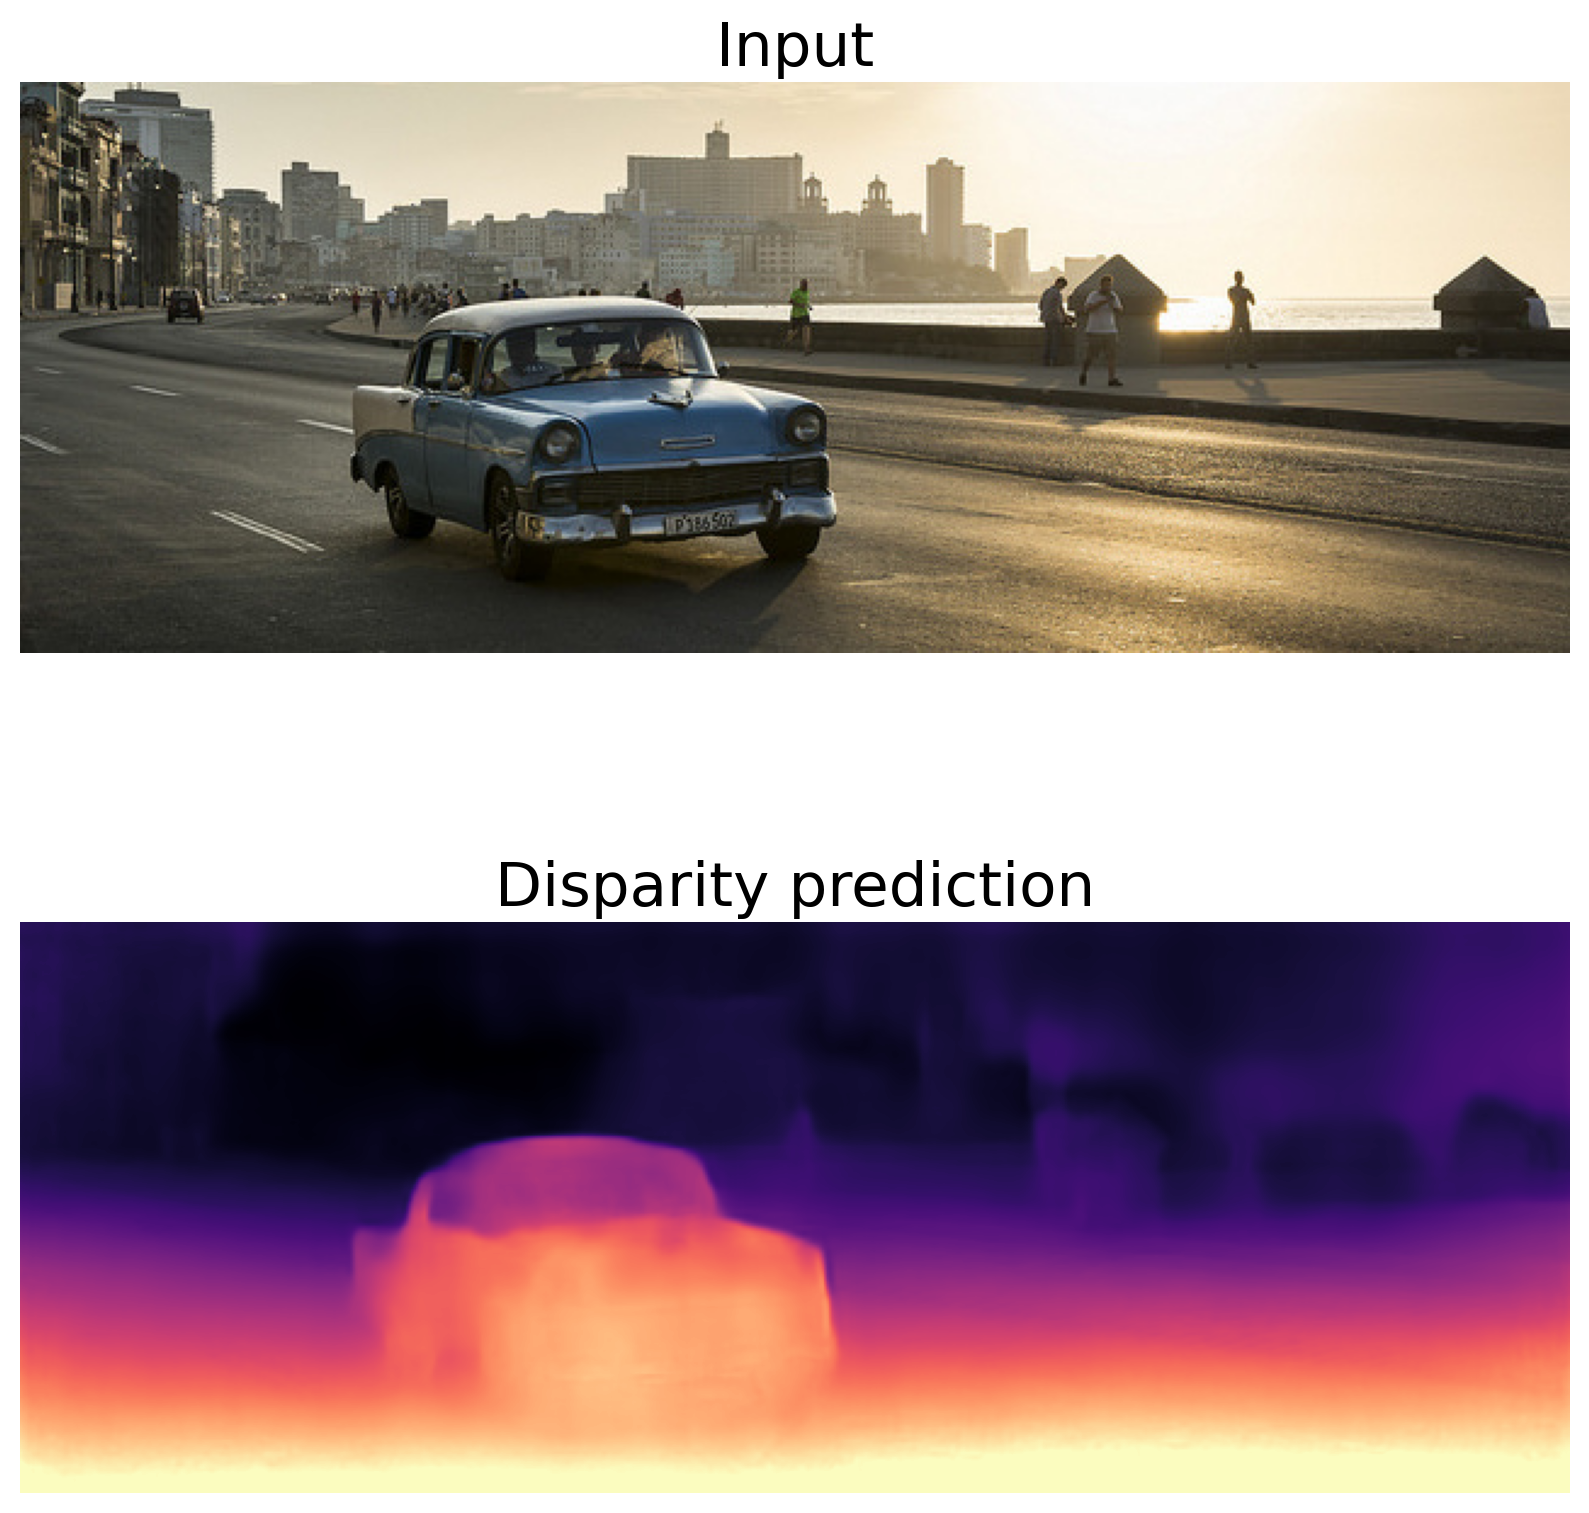

In [3]:
# 高级部分: 深度估计
import sys
sys.path.append('.')  # 将当前目录添加到Python路径中
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import monodepth2.networks as networks

def depth_estimation_demo():
    model_name = "SNN_mono"
    
    # 修改模型路径
    encoder_path = os.path.join("monodepth2/models", model_name, "encoder.pth")
    depth_decoder_path = os.path.join("monodepth2/models", model_name, "depth.pth")

    # 加载模型
    encoder = networks.SResnetEncoder(18, False)
    depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

    # 加载权重
    loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
    filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
    encoder.load_state_dict(filtered_dict_enc)

    loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
    depth_decoder.load_state_dict(loaded_dict)

    encoder.eval()
    depth_decoder.eval()

    # 加载测试图片
    image_path = "monodepth2/assets/test_image.jpg"
    input_image = pil.open(image_path).convert('RGB')
    original_width, original_height = input_image.size

    # 预处理
    feed_height = loaded_dict_enc['height'] 
    feed_width = loaded_dict_enc['width']
    input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)
    input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

disp_resized.squeeze().cpu().numpy()
    vmax = np.percentile(disp_resized_np, 95)

    plt.figure(figsize=(10, 10), dpi=200)
    plt.subplot(211)
    plt.imshow(input_image)
    plt.title("Input", fontsize=22)
    plt.axis('off')

    plt.subplot(212)
    plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
    plt.title("Disparity prediction", fontsize=22)
    plt.axis('off')

depth_estimation_demo()